In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/08


In [30]:
sig_df = pd.read_pickle('Pkl_ips/SC_SUSY_242_5_mchi_60.pkl')
tt_df  = pd.read_pickle('Pkl_ips/SC_ttbar.pkl')
vv_df  = pd.read_pickle('Pkl_ips/SC_VV.pkl')
st_df  = pd.read_pickle('Pkl_ips/SC_ST.pkl')
sat_df = pd.read_pickle('Pkl_ips/SC_SAT.pkl')

<ipython-input-4-4aad18c650db>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


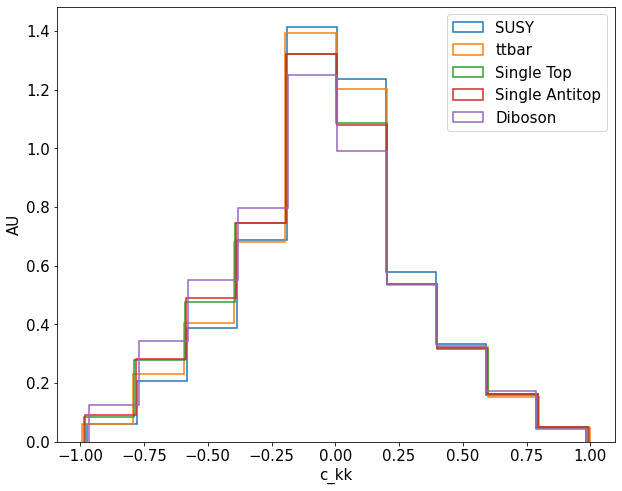

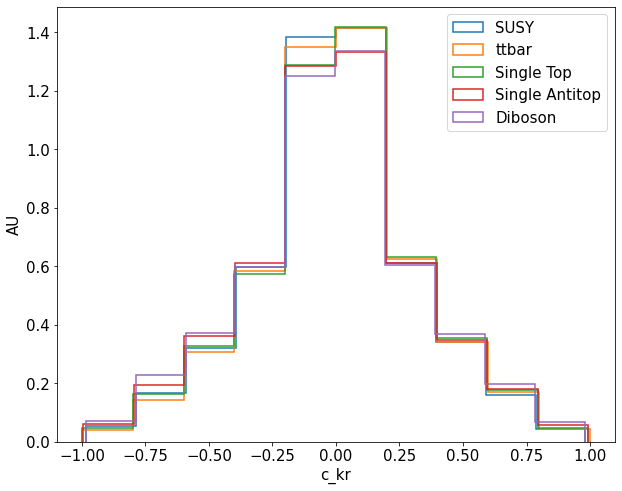

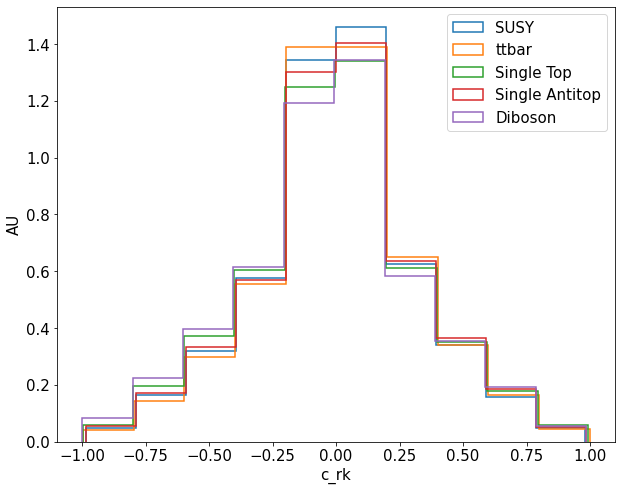

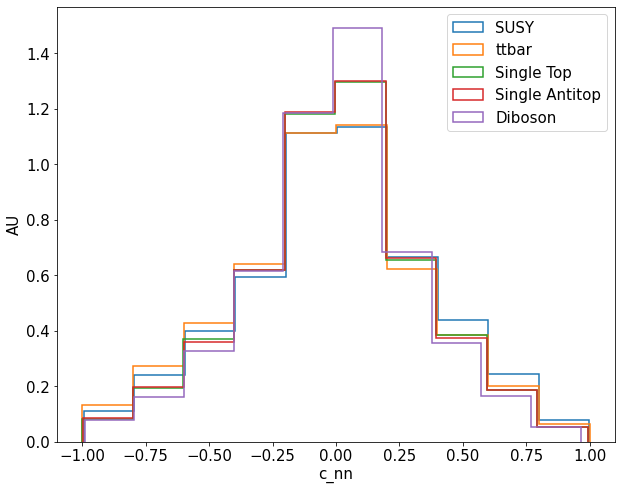

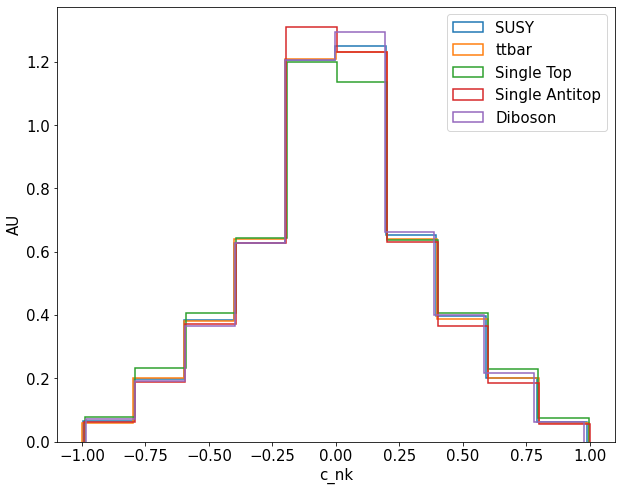

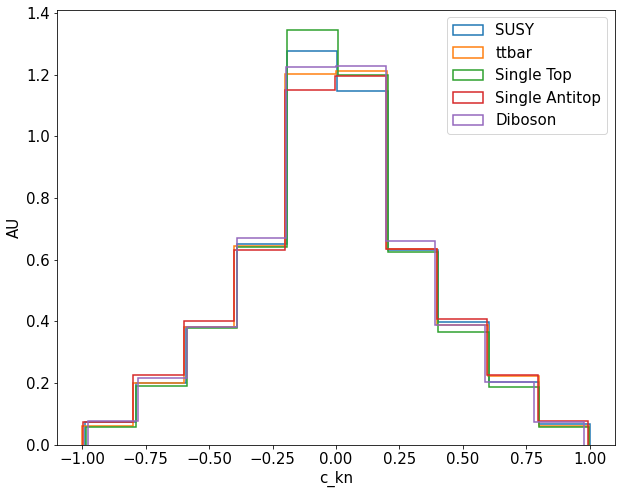

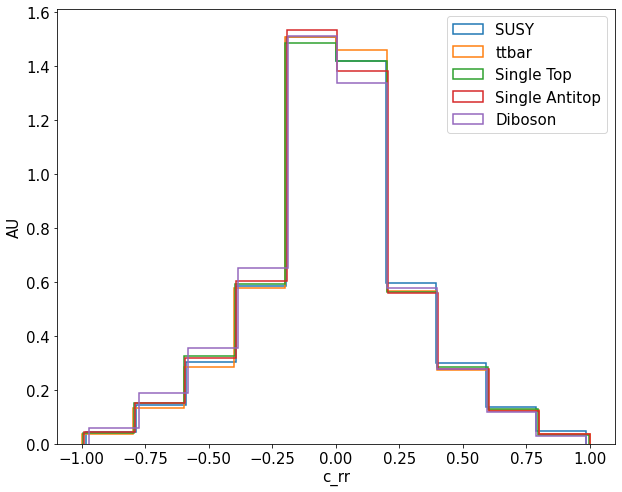

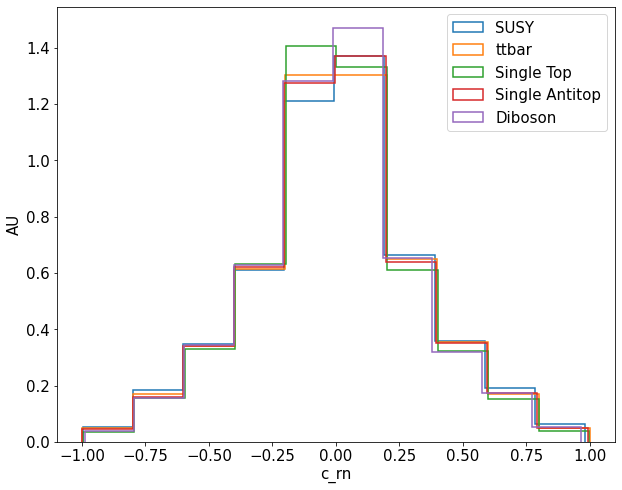

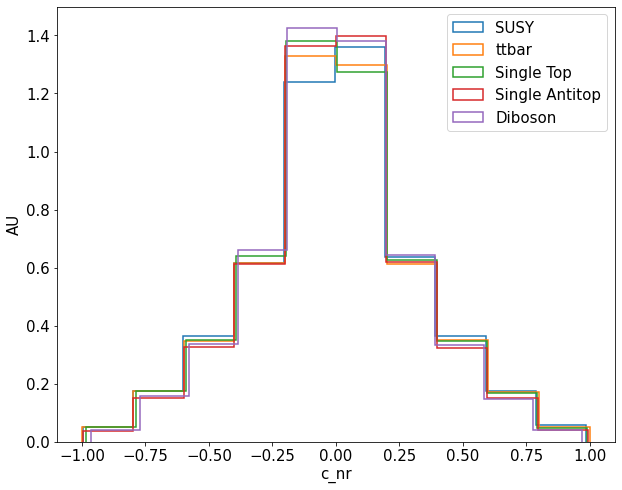

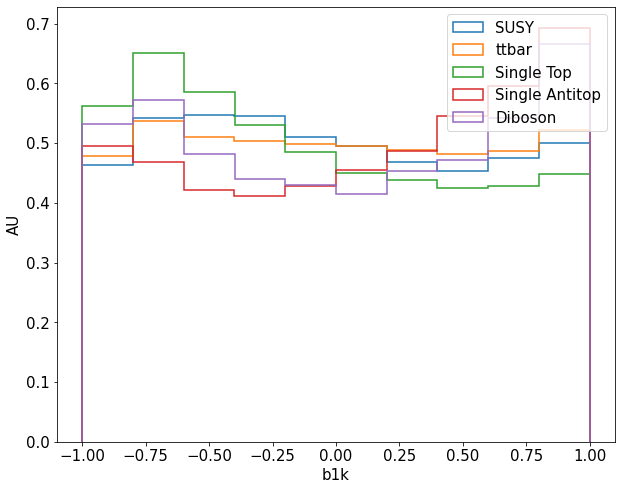

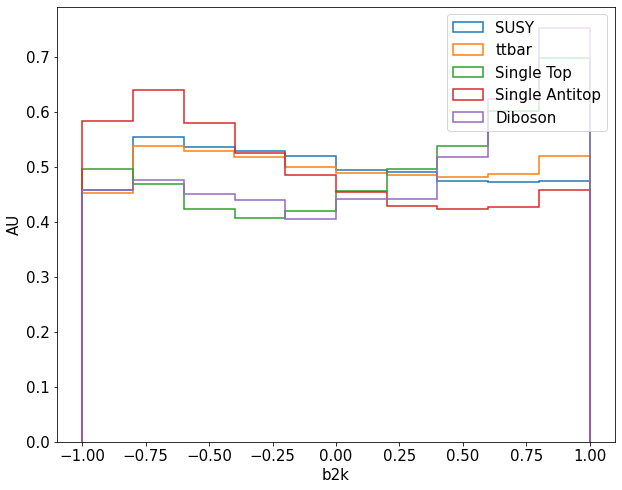

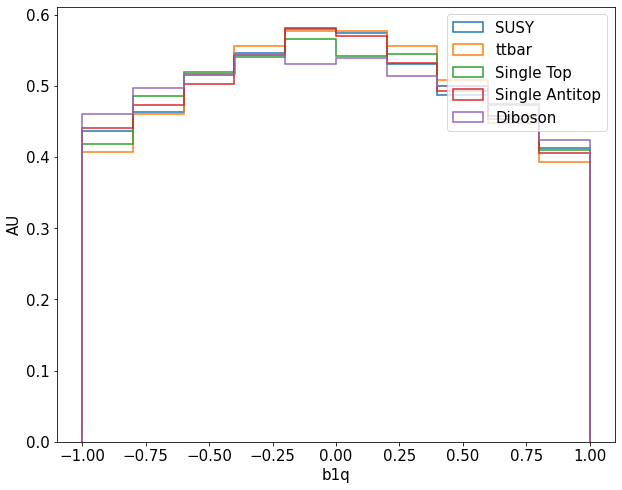

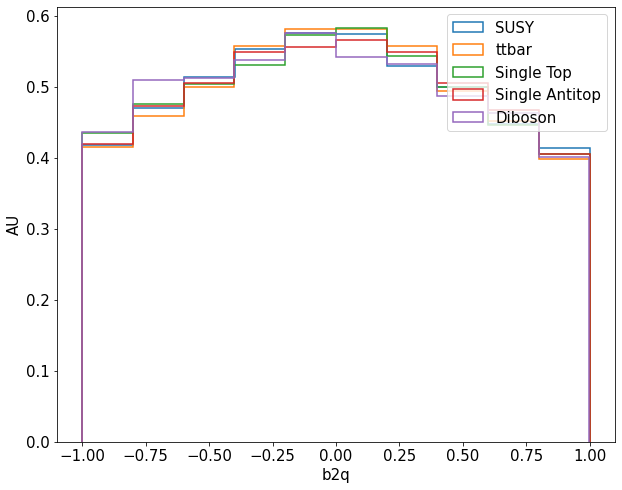

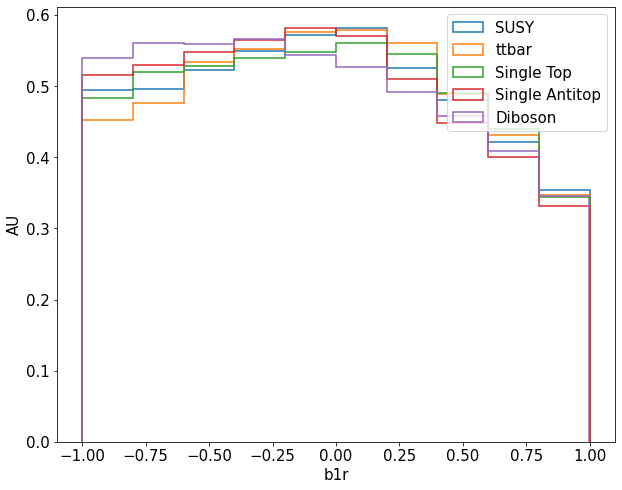

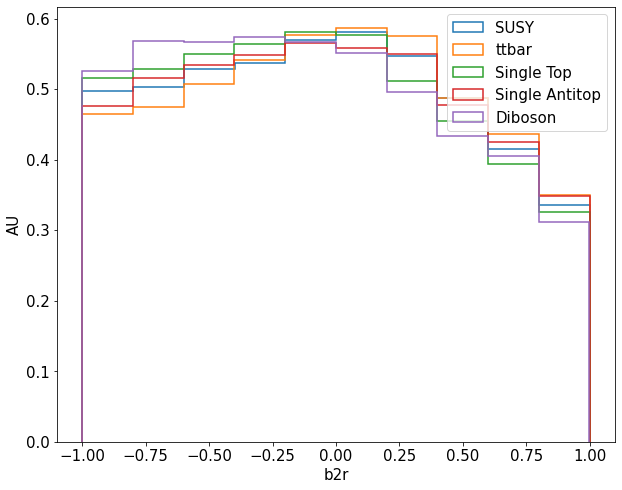

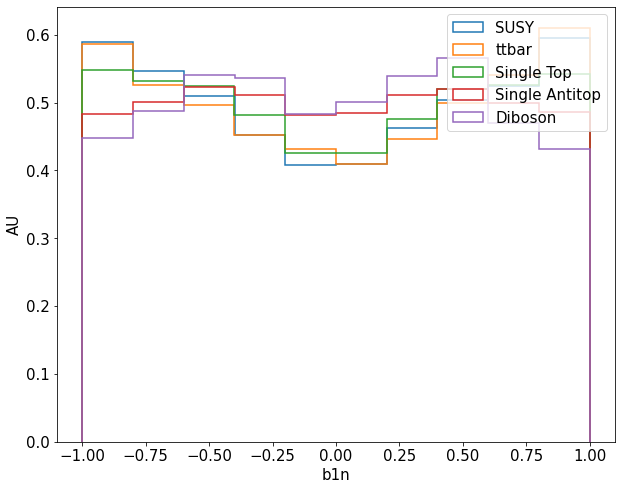

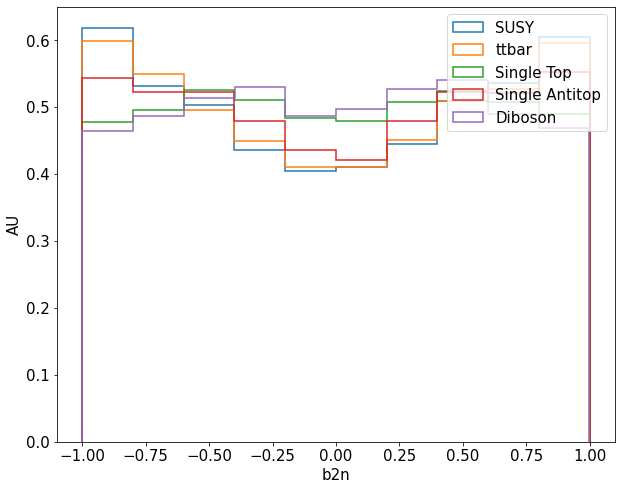

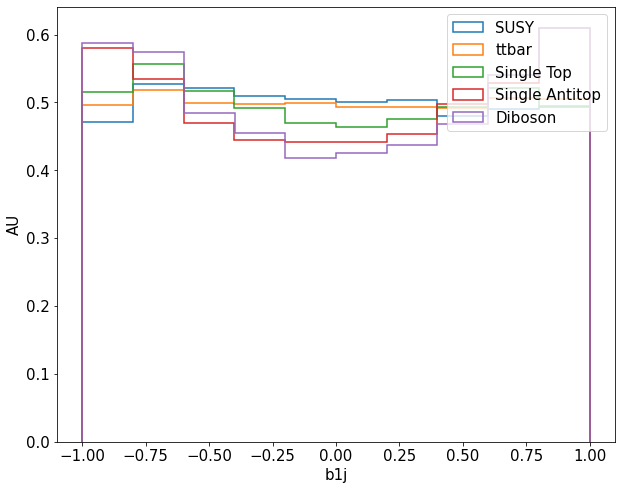

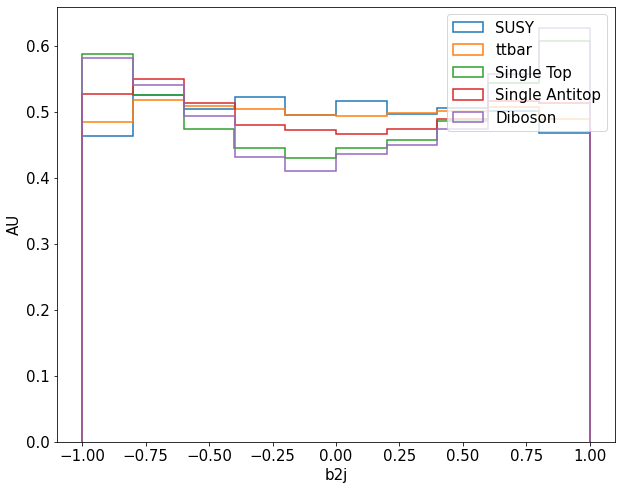

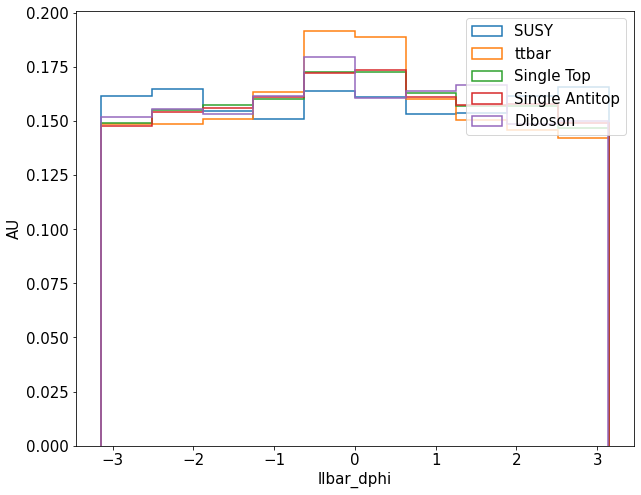

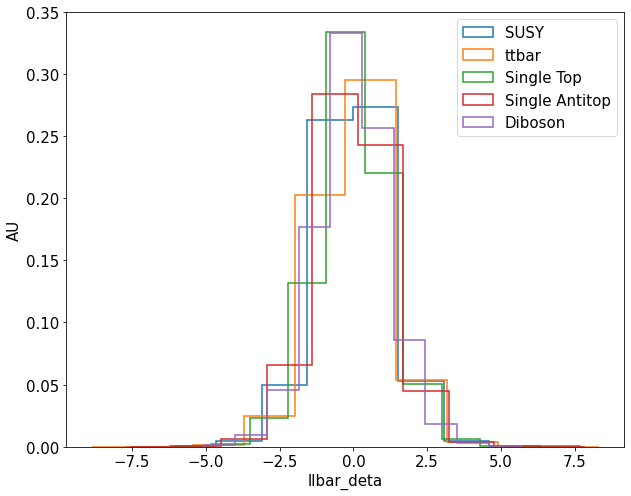

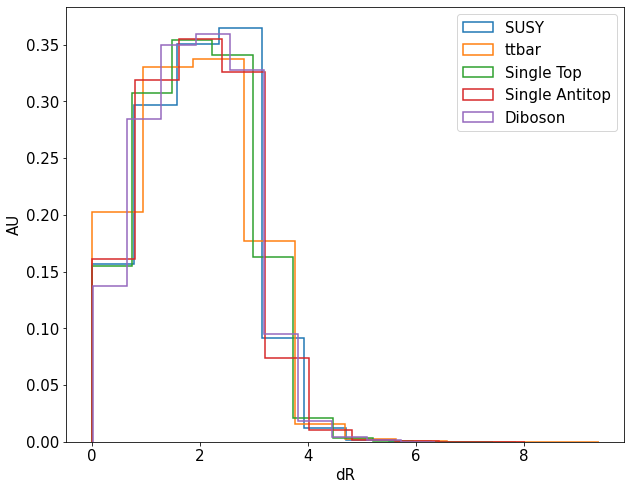

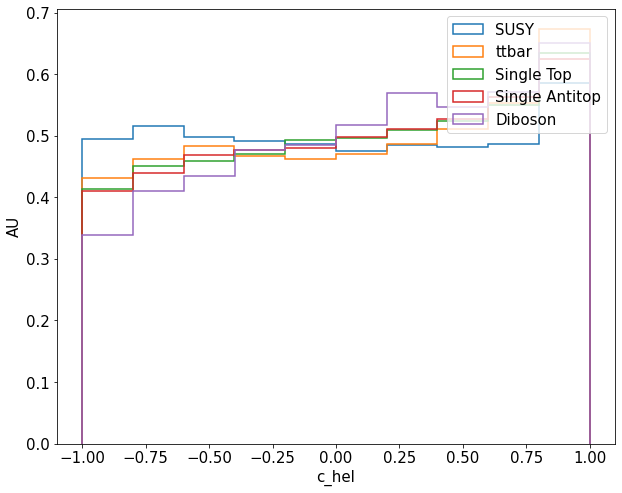

In [4]:
x_labels = sig_df.columns
count    = 0

for i in sig_df.columns :
    plt.figure(figsize=(10,8))
    # Plot the histograms
    plt.hist(sig_df[i], histtype='step', density=True, linewidth=1.5, label='SUSY')
    plt.hist(tt_df[i] , histtype='step', density=True, linewidth=1.5, label='ttbar')
    plt.hist(st_df[i] , histtype='step', density=True, linewidth=1.5, label='Single Top')
    plt.hist(sat_df[i], histtype='step', density=True, linewidth=1.5, label='Single Antitop')
    plt.hist(vv_df[i] , histtype='step', density=True, linewidth=1.5, label='Diboson')
    
    # Formatting
    plt.xlabel(x_labels[count], fontsize=15)
    plt.ylabel('AU', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)

    img_name = 'Images/Mstop_242_5_' + str(x_labels[count]) + '.jpg' 
    count   += 1
    plt.savefig(img_name)

In [31]:
# Standardize
sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean = tt_df.mean()
tt_std  = tt_df.std()

st_mean = st_df.mean()
st_std  = st_df.std()

vv_mean = vv_df.mean()
vv_std  = vv_df.std()

sat_mean = sat_df.mean()
sat_std  = sat_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std
st_df  = (st_df  - st_mean)/ st_std
vv_df  = (vv_df  - vv_mean)/ vv_std
sat_df = (sat_df  - sat_mean)/ sat_std

In [32]:
# Set both to equal sizes 
# Reducing the bkg dataframe size

sig_df_train = sig_df[1:17000]
tt_df_train  = tt_df[1:35000]
st_df_train  = st_df[1:10000]
sat_df_train = sat_df[1:10000]
vv_df_train  = vv_df[1:2000]

In [33]:
bkgList = [tt_df_train, st_df_train, sat_df_train, vv_df_train]  # List of your dataframes

bkg_df_train = pd.concat(bkgList)

signal = sig_df_train.values
bkg    = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [34]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7ff2117b6cf0>

In [35]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

TRAIN: [    1     3     5 ... 73990 73992 73994] TEST: [    0     2     4 ... 73987 73991 73993]
TRAIN: [    0     2     4 ... 73987 73991 73993] TEST: [    1     3     5 ... 73990 73992 73994]


In [36]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [37]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from skopt import gp_minimize

model = Sequential()
model.add(Dense(200, input_dim = 23  ,activation='relu'))
model.add(Dropout(0.1))
#model.add(Dense(100, input_dim = 100 ,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               4800      
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


In [38]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [39]:
hist = model.fit(x_train, y_train, batch_size=100, epochs=1000,verbose=1, shuffle=True, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5718 - accuracy: 0.7325 - val_loss: 0.5458 - val_accuracy: 0.7684
Epoch 2/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5380 - accuracy: 0.7719 - val_loss: 0.5434 - val_accuracy: 0.7684
Epoch 3/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5364 - accuracy: 0.7689 - val_loss: 0.5407 - val_accuracy: 0.7684
Epoch 4/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5307 - accuracy: 0.7728 - val_loss: 0.5413 - val_accuracy: 0.7684
Epoch 5/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5317 - accuracy: 0.7699 - val_loss: 0.5382 - val_accuracy: 0.7684
Epoch 6/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5302 - accuracy: 0.7700 - val_loss: 0.5346 - val_accuracy: 0.7684
Epoch 7/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5267 - accuracy: 0.7701 - val_loss: 0.5353 - val_accuracy:

296/296 [==============================] - 1s 4ms/step - loss: 0.3633 - accuracy: 0.8415 - val_loss: 0.3455 - val_accuracy: 0.8234
Epoch 58/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.3642 - accuracy: 0.8388 - val_loss: 0.3381 - val_accuracy: 0.8558
Epoch 59/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.3566 - accuracy: 0.8468 - val_loss: 0.3365 - val_accuracy: 0.8408
Epoch 60/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.3596 - accuracy: 0.8443 - val_loss: 0.3306 - val_accuracy: 0.8580
Epoch 61/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.3575 - accuracy: 0.8437 - val_loss: 0.3276 - val_accuracy: 0.8503
Epoch 62/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.3459 - accuracy: 0.8502 - val_loss: 0.3329 - val_accuracy: 0.8288
Epoch 63/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.3486 - accuracy: 0.8458 - val_loss: 0.3254 - val_accuracy: 0.8509

296/296 [==============================] - 1s 3ms/step - loss: 0.2653 - accuracy: 0.8910 - val_loss: 0.2299 - val_accuracy: 0.8999
Epoch 114/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2620 - accuracy: 0.8922 - val_loss: 0.2224 - val_accuracy: 0.9041
Epoch 115/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.2608 - accuracy: 0.8933 - val_loss: 0.2200 - val_accuracy: 0.9099
Epoch 116/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2553 - accuracy: 0.8962 - val_loss: 0.2122 - val_accuracy: 0.9251
Epoch 117/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.2531 - accuracy: 0.8977 - val_loss: 0.2150 - val_accuracy: 0.9143
Epoch 118/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.2485 - accuracy: 0.8992 - val_loss: 0.2178 - val_accuracy: 0.9074
Epoch 119/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2559 - accuracy: 0.8943 - val_loss: 0.2165 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.1920 - accuracy: 0.9256 - val_loss: 0.1558 - val_accuracy: 0.9493
Epoch 170/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1967 - accuracy: 0.9227 - val_loss: 0.1585 - val_accuracy: 0.9411
Epoch 171/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1955 - accuracy: 0.9234 - val_loss: 0.1628 - val_accuracy: 0.9368
Epoch 172/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1975 - accuracy: 0.9232 - val_loss: 0.1521 - val_accuracy: 0.9530
Epoch 173/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1917 - accuracy: 0.9229 - val_loss: 0.1624 - val_accuracy: 0.9361
Epoch 174/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1853 - accuracy: 0.9280 - val_loss: 0.1542 - val_accuracy: 0.9532
Epoch 175/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1847 - accuracy: 0.9294 - val_loss: 0.1585 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.1431 - accuracy: 0.9489 - val_loss: 0.1174 - val_accuracy: 0.9627
Epoch 226/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1469 - accuracy: 0.9457 - val_loss: 0.1112 - val_accuracy: 0.9664
Epoch 227/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1453 - accuracy: 0.9450 - val_loss: 0.1129 - val_accuracy: 0.9647
Epoch 228/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1473 - accuracy: 0.9457 - val_loss: 0.1112 - val_accuracy: 0.9666
Epoch 229/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1455 - accuracy: 0.9456 - val_loss: 0.1129 - val_accuracy: 0.9665
Epoch 230/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1447 - accuracy: 0.9451 - val_loss: 0.1138 - val_accuracy: 0.9603
Epoch 231/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1445 - accuracy: 0.9461 - val_loss: 0.1059 - val_accuracy: 

296/296 [==============================] - 1s 3ms/step - loss: 0.1127 - accuracy: 0.9614 - val_loss: 0.0873 - val_accuracy: 0.9764
Epoch 282/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1144 - accuracy: 0.9593 - val_loss: 0.0844 - val_accuracy: 0.9746
Epoch 283/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1193 - accuracy: 0.9567 - val_loss: 0.0838 - val_accuracy: 0.9728
Epoch 284/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1079 - accuracy: 0.9606 - val_loss: 0.0821 - val_accuracy: 0.9781
Epoch 285/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1119 - accuracy: 0.9601 - val_loss: 0.0815 - val_accuracy: 0.9789
Epoch 286/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1107 - accuracy: 0.9603 - val_loss: 0.0891 - val_accuracy: 0.9743
Epoch 287/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1131 - accuracy: 0.9591 - val_loss: 0.0797 - val_accuracy: 

296/296 [==============================] - 1s 3ms/step - loss: 0.0927 - accuracy: 0.9675 - val_loss: 0.0676 - val_accuracy: 0.9765
Epoch 338/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0926 - accuracy: 0.9674 - val_loss: 0.0681 - val_accuracy: 0.9797
Epoch 339/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0944 - accuracy: 0.9666 - val_loss: 0.0660 - val_accuracy: 0.9805
Epoch 340/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0938 - accuracy: 0.9672 - val_loss: 0.0734 - val_accuracy: 0.9755
Epoch 341/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0902 - accuracy: 0.9670 - val_loss: 0.0624 - val_accuracy: 0.9826
Epoch 342/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0876 - accuracy: 0.9696 - val_loss: 0.0644 - val_accuracy: 0.9811
Epoch 343/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0886 - accuracy: 0.9692 - val_loss: 0.0663 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.0778 - accuracy: 0.9732 - val_loss: 0.0561 - val_accuracy: 0.9842
Epoch 394/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0797 - accuracy: 0.9723 - val_loss: 0.0611 - val_accuracy: 0.9805
Epoch 395/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0804 - accuracy: 0.9715 - val_loss: 0.0605 - val_accuracy: 0.9789
Epoch 396/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.9736 - val_loss: 0.0545 - val_accuracy: 0.9839
Epoch 397/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0797 - accuracy: 0.9736 - val_loss: 0.0557 - val_accuracy: 0.9835
Epoch 398/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0816 - accuracy: 0.9693 - val_loss: 0.0538 - val_accuracy: 0.9838
Epoch 399/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0772 - accuracy: 0.9737 - val_loss: 0.0567 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9740 - val_loss: 0.0512 - val_accuracy: 0.9823
Epoch 450/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0693 - accuracy: 0.9738 - val_loss: 0.0510 - val_accuracy: 0.9847
Epoch 451/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0680 - accuracy: 0.9764 - val_loss: 0.0482 - val_accuracy: 0.9842
Epoch 452/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0682 - accuracy: 0.9762 - val_loss: 0.0489 - val_accuracy: 0.9849
Epoch 453/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0662 - accuracy: 0.9761 - val_loss: 0.0484 - val_accuracy: 0.9858
Epoch 454/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0691 - accuracy: 0.9748 - val_loss: 0.0448 - val_accuracy: 0.9873
Epoch 455/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0713 - accuracy: 0.9741 - val_loss: 0.0510 - val_accuracy: 

296/296 [==============================] - 1s 3ms/step - loss: 0.0633 - accuracy: 0.9778 - val_loss: 0.0422 - val_accuracy: 0.9873
Epoch 506/1000
296/296 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - 1s 3ms/step - loss: 0.0636 - accuracy: 0.9775 - val_loss: 0.0437 - val_accuracy: 0.9864
Epoch 507/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0633 - accuracy: 0.9781 - val_loss: 0.0473 - val_accuracy: 0.9841
Epoch 508/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0704 - accuracy: 0.9742 - val_loss: 0.0440 - val_accuracy: 0.9861
Epoch 509/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0674 - accuracy: 0.9751 - val_loss: 0.0462 - val_accuracy: 0.9857
Epoch 510/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0614 - accuracy: 0.9792 - val_loss: 0.0442 - val_accuracy: 0.9858
Epoch 511/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0636 - accuracy: 

In [75]:
'''
# serialize model to JSON
model_json = model.to_json()
with open("Mstop_182_5_mchi_7_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Mstop_182_5_mchi_7_5.h5")
print("Saved model to disk")
'''

Saved model to disk


In [21]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'accuracy' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['accuracy'][-1])
            do_acc = True
        if 'val_accuracy' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_accuracy'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Accuracy' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'accuracy' in loss.history:
            plt.plot(loss.history['accuracy'], lw=2, label=label+" accuracy", color=color)
        if 'val_accuracy' in loss.history:
            plt.plot(loss.history['val_accuracy'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(fontsize=17)
    plt.show()

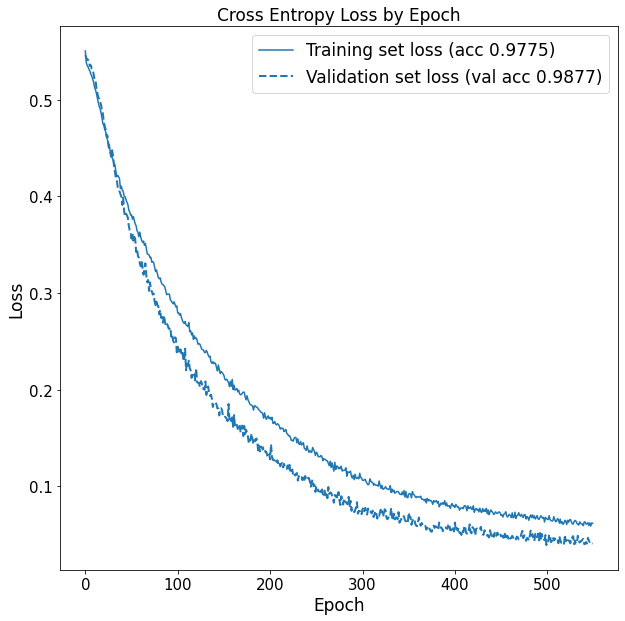

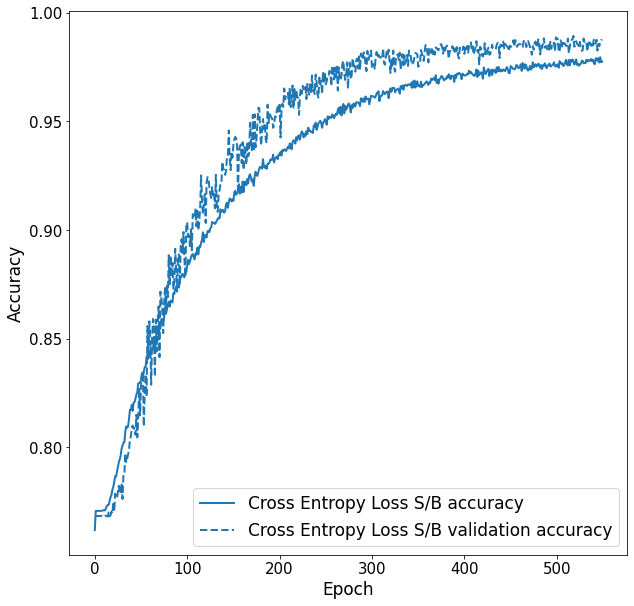

In [40]:
show_losses( [("Cross Entropy Loss S/B", hist)])

In [41]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [42]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

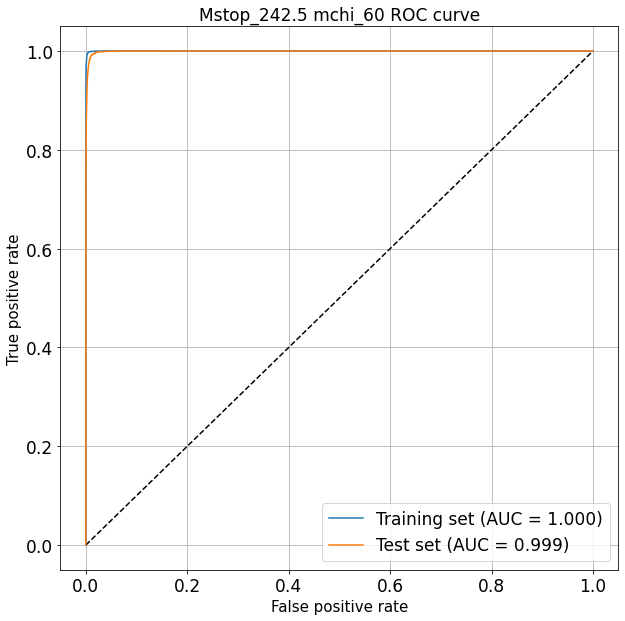

In [25]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_242.5 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
plt.savefig('ROC Mstop 242.5 Mchi 60.jpg')
plt.show()

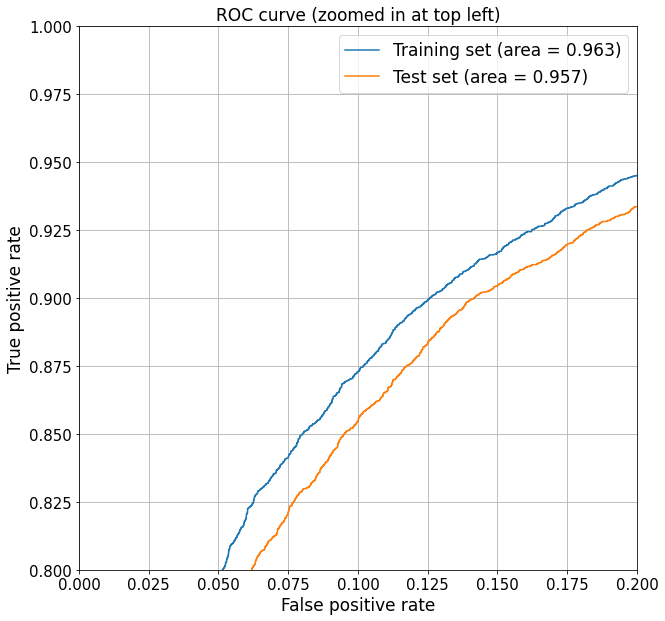

In [72]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(10,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (area = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (area = {:.3f})'.format(auc_keras_test))
plt.ylabel('True positive rate' , fontsize=17)
plt.xlabel('False positive rate', fontsize=17)
plt.tick_params(axis="y", labelsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.title('ROC curve (zoomed in at top left)', fontsize=17)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show()

In [43]:
tt_pred  = model.predict(tt_df[35000:]) 
st_pred  = model.predict(st_df[10000:]) 
sat_pred = model.predict(sat_df[10000:]) 
vv_pred  = model.predict(vv_df[2000:]) 
si_pred  = model.predict(sig_df[17000:])

2021-04-04 23:14:45.162568: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 253456320 exceeds 10% of free system memory.


In [20]:
st_list = [st_pred, sat_pred]
st_arr  = np.array(st_list)

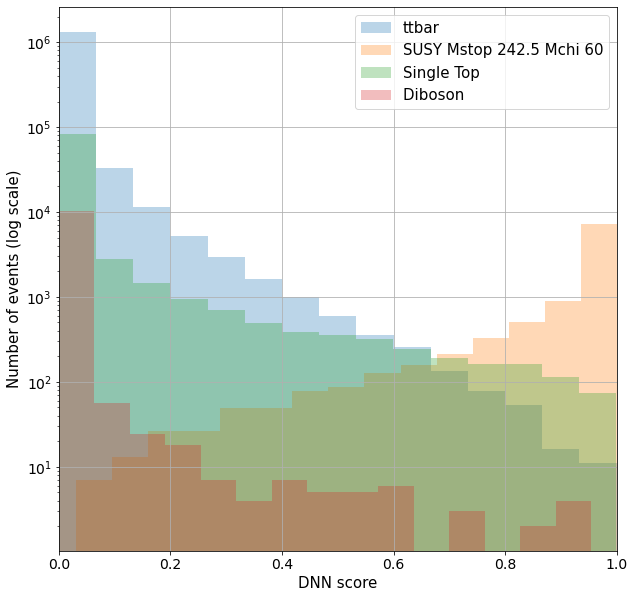

In [45]:
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(tt_pred, bins=15, alpha=0.3, label='ttbar')
plt.hist(si_pred, bins=15, alpha=0.3, label='SUSY Mstop 242.5 Mchi 60')
plt.hist(st_pred, bins=15, alpha=0.3, label='Single Top')
plt.hist(vv_pred, bins=15, alpha=0.3, label='Diboson ')
#plt.hist(sat_pred, bins=15, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('DNN score Mstop_242.5 Mchi_60.jpg')

In [18]:
np.savetxt('Mstop_182_5_mchi_7_5_SUSY_pred.txt', si_pred)
np.savetxt('Mstop_182_5_mchi_7_5_tt_pred.txt'  , tt_pred)
np.savetxt('Mstop_182_5_mchi_7_5_st_pred.txt'  , st_pred)
np.savetxt('Mstop_182_5_mchi_7_5_sat_pred.txt' , sat_pred)
np.savetxt('Mstop_182_5_mchi_7_5_vv_pred.txt'  , vv_pred)

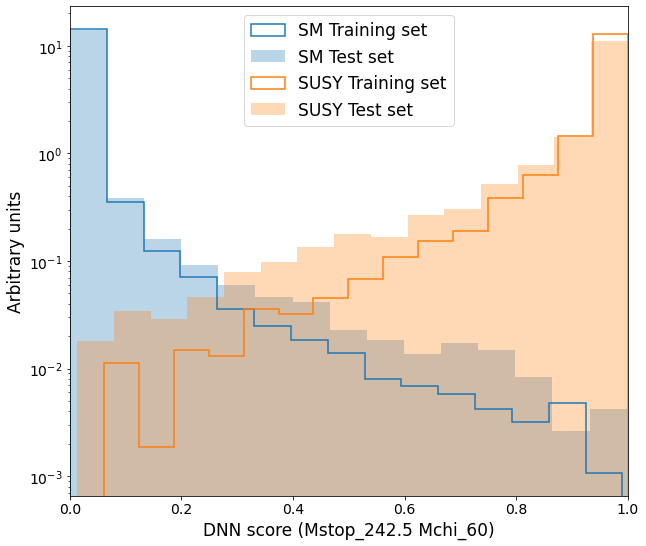

In [46]:
c0 = 'C0'
c1 = 'C1'
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=15, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[y_test == 0]  , bins=15, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_train[y_train == 1], bins=15, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[y_test == 1]  , bins=15, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
#plt.ylim(0.1, 30)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_242.5 Mchi_60)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)
#plt.savefig('Train vs test Mstop_242.5 Mchi_60.jpg')

In [72]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()
    sns.set(font_scale=1.4)
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    #cmap = sns.diverging_palette(250, 10, as_cmap=True)
    #cmap  = sns.color_palette("coolwarm")
    cmap = sns.diverging_palette(0,255,sep=1, as_cmap=True)
                                 
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        hm = sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)
        plt.title('Correlation matrix for input features', fontsize=30)
        plt.savefig('ip_features_corr.png')
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)

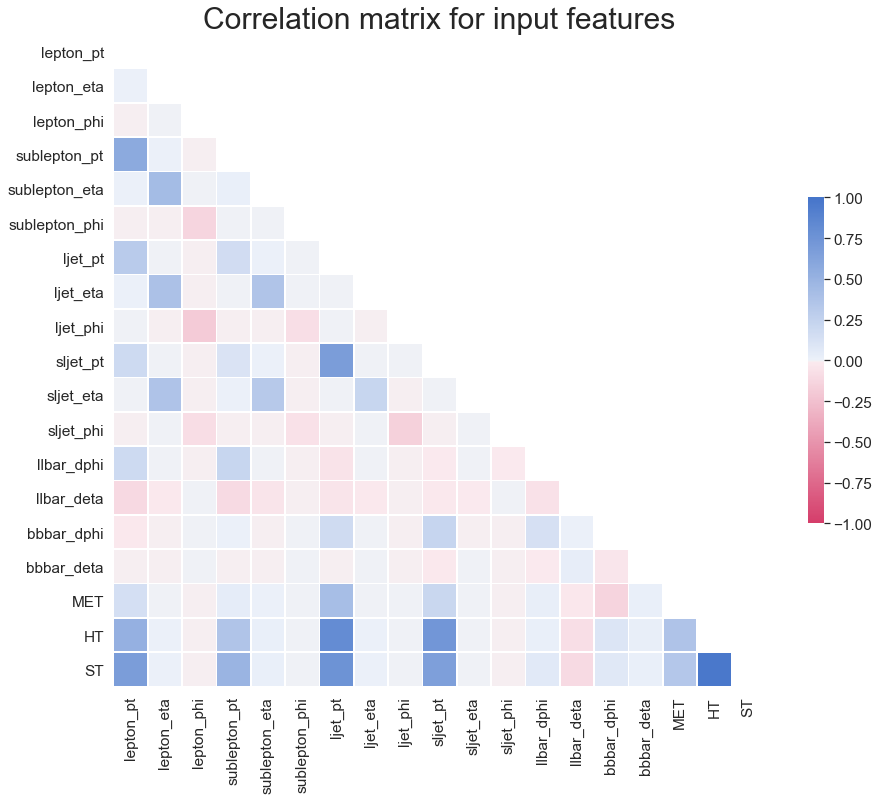

In [73]:
CorrMtx(corr, dropDuplicates = True)

In [47]:
len(sig_df)

26801

In [48]:
len(st_df)

100988

In [49]:
len(sat_df)

99855

In [50]:
len(tt_df)

1412480

In [51]:
len(vv_df)

12309